In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
products = pd.read_csv("data_raw/instacart/products.csv")
orders = pd.read_csv("data_raw/instacart/orders.csv")
aisles = pd.read_csv("data_raw/instacart/aisles.csv")
departments = pd.read_csv("data_raw/instacart/departments.csv")
order_product = pd.read_csv("data_raw/instacart/order_products__prior.csv")[["order_id", "product_id"]]
order_nproducts = order_product.groupby("order_id", as_index=False).agg({"product_id":"count"}).rename(columns={"product_id":"different_products"})
orders_prior = orders[orders["order_id"].isin(order_nproducts["order_id"].unique())].merge(order_nproducts, how="left", left_on="order_id", right_on="order_id")
orders_prior["lunes"] = (orders_prior["order_dow"] == 0).astype(int)
orders_prior["martes"] = (orders_prior["order_dow"] == 1).astype(int)
orders_prior["miercoles"] = (orders_prior["order_dow"] == 2).astype(int)
orders_prior["jueves"] = (orders_prior["order_dow"] == 3).astype(int)
orders_prior["viernes"] = (orders_prior["order_dow"] == 4).astype(int)
orders_prior["sabado"] = (orders_prior["order_dow"] == 5).astype(int)
orders_prior["domingo"] = (orders_prior["order_dow"] == 6).astype(int)
orders_prior["am"] = (orders_prior["order_hour_of_day"] <12).astype(int)
orders_prior["pm"] = (orders_prior["order_hour_of_day"] >= 12).astype(int)

In [3]:
# Cambiamos tipo de 

In [4]:
print("Cantidad de boletas: " + str(len(order_product)))
print("Cantidad de productos: " + str(len(products["product_id"])))

Cantidad de boletas: 32434489
Cantidad de productos: 49688


<Axes: xlabel='order_count', ylabel='Count'>

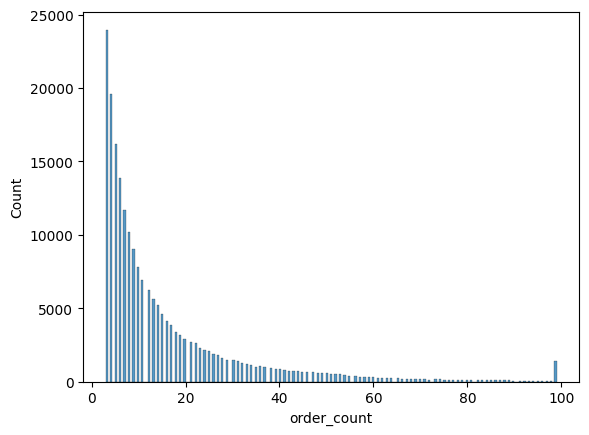

In [7]:
users = orders_prior.groupby("user_id", as_index=False).agg({"order_id":"count", "different_products":"max"}).rename(columns={"order_id":"order_count"})
#users=users[(users["order_count"]<=10)]
sns.histplot(users["order_count"])

In [9]:
random.seed(12345)
print("Cantidad de clientes originales: ", str(len(orders_prior["user_id"].unique())))
users_sample = random.sample(users["user_id"].unique().tolist(), 15)
order_sample = orders_prior[orders_prior["user_id"].isin(users_sample)]["order_id"].unique()
op_sample = order_product[(order_product["order_id"].isin(order_sample))].copy()

print("Cantidad de productos en la muestra: " + str(len(op_sample.product_id.unique())))
print("Cantidad de boletas en la muestra: " + str(len(order_sample)))
op_count = op_sample.groupby(["order_id"], as_index=False).agg({"product_id":"count"}).rename(columns={"product_id":"product_count"})
print("Cantidad de productos comprados: " + str(op_count["product_count"].sum()))

products_sample = products[products["product_id"].isin(op_sample["product_id"].unique())].copy()
orders_sample = orders_prior[orders_prior["order_id"].isin(order_sample)].copy()

# Reiniciamos los id de los samples
products_sample["product_id_old"] = products_sample["product_id"]
products_sample = products_sample.reset_index(drop=True)
products_sample["product_id"] = range(1, len(products_sample) + 1)

products_sample["department_id_old"] = products_sample["department_id"]
products_sample["department_id"] = pd.factorize(products_sample["department_id"])[0] + 1

products_sample["aisle_id_old"] = products_sample["aisle_id"]
products_sample["aisle_id"] = pd.factorize(products_sample["aisle_id"])[0] + 1

orders_sample["order_id_old"] = orders_sample["order_id"]
orders_sample = orders_sample.reset_index(drop=True)
orders_sample["order_id"] = range(1, len(orders_sample) + 1)

user_map = {users_sample[i]:i+1 for i in range(len(users_sample))}
orders_sample["user_id"] = orders_sample["user_id"].map(user_map)

op_sample["order_id_old"] = op_sample["order_id"]
op_sample["product_id_old"] = op_sample["product_id"]

op_sample.drop(columns=["order_id", "product_id"], inplace=True)

op_sample = op_sample.merge(how="left", right=orders_sample[["order_id", "order_id_old"]], on="order_id_old")
op_sample = op_sample.merge(how="left", right=products_sample[["product_id", "product_id_old"]], on="product_id_old")
op_sample.drop(columns=["order_id_old", "product_id_old"], inplace=True)

print("Cantidad de clientes en la muestra: ", str(len(orders_sample["user_id"].unique())))
products_sample = products_sample.merge(aisles, how="left", on="aisle_id").merge(departments, how="left", on="department_id")[["product_id", "product_name", "aisle", "department", "aisle_id"]]
orders_sample = orders_sample[["order_id", "user_id", "order_number", "lunes", "martes", "miercoles", "jueves", "viernes", "sabado","domingo", "am", "pm"]]

print("boletas * productos: " + str(len(order_sample)*len(op_sample.product_id.unique())))

Cantidad de clientes originales:  206209
Cantidad de productos en la muestra: 813
Cantidad de boletas en la muestra: 208
Cantidad de productos comprados: 1806
Cantidad de clientes en la muestra:  15
boletas * productos: 169104


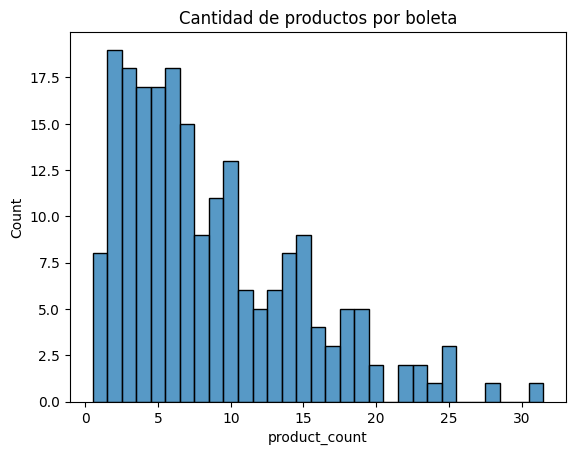

In [10]:
sns.histplot(op_count["product_count"], discrete=True)
plt.title("Cantidad de productos por boleta")
plt.show()

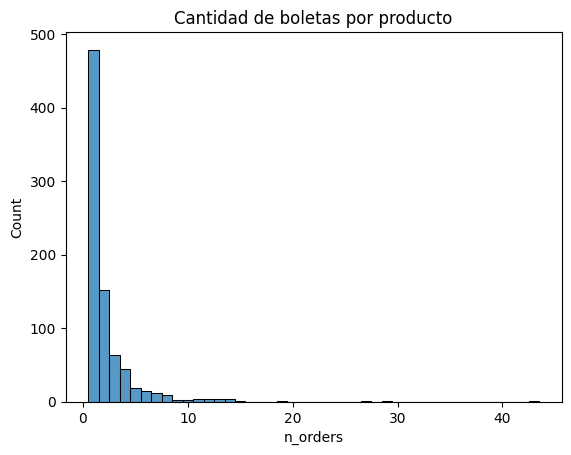

In [11]:
product_baskets = op_sample.groupby(["product_id"], as_index=False).agg({"order_id":"count"}).rename(columns={"order_id":"n_orders"})
product_baskets["relative_orders"] = product_baskets["n_orders"]/len(op_sample.order_id.unique())
product_baskets = product_baskets.merge(right=products, left_on="product_id", right_on="product_id", how="left")
sns.histplot(product_baskets[product_baskets["n_orders"]<=50]["n_orders"], discrete=True)
plt.title("Cantidad de boletas por producto")
plt.show()

<Axes: xlabel='order_count', ylabel='Count'>

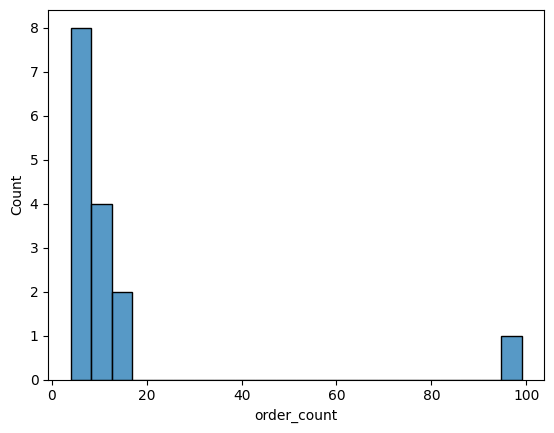

In [12]:
users_sample = orders_sample.groupby("user_id", as_index=False).agg({"order_id":"count","am":"mean", "pm":"mean", "lunes":"mean", "miercoles":"mean", "viernes":"mean", "domingo":"mean"}).rename(columns={"order_id":"order_count"})
sns.histplot(users_sample[users_sample["order_count"]>1]["order_count"])

In [13]:
orders_sample.to_csv("data/instacart/orders_sample.csv", index=False)
products_sample.to_csv("data/instacart/products_sample.csv", index=False)
op_sample.to_csv("data/instacart/order_product_sample.csv", index=False)

In [14]:
products_sample.head()

,product_id,product_name,aisle,department,aisle_id
0,1,Classics Earl Grey Tea,prepared soups salads,frozen,1
1,2,100% Recycled Aluminum Foil,specialty cheeses,other,2
2,3,Dried Sweetened Cranberries,energy granola bars,bakery,3
3,4,Instant Mashed Potatoes,instant foods,produce,4
4,5,Garnet Sweet Potato (Yam),marinades meat preparation,alcohol,5


In [15]:
orders_sample.head()

,order_id,user_id,order_number,lunes,martes,miercoles,jueves,viernes,sabado,domingo,am,pm
0,1,3,1,1,0,0,0,0,0,0,0,1
1,2,3,2,1,0,0,0,0,0,0,0,1
2,3,3,3,0,0,1,0,0,0,0,0,1
3,4,3,4,0,1,0,0,0,0,0,0,1
4,5,12,1,0,0,1,0,0,0,0,1,0


In [16]:
op_sample.head()

,order_id,product_id
0,77,419
1,77,10
2,122,746
3,122,69
4,10,773


In [17]:
pc_sample = op_sample.groupby("product_id", as_index=False).agg({"order_id":"count"}).rename(columns={"order_id":"n_orders"})
pc_sample[pc_sample["n_orders"]==0].product_id.count()

np.int64(0)

In [18]:
op_sample

,order_id,product_id
0,77,419
1,77,10
2,122,746
3,122,69
4,10,773
...,...,...
1801,127,760
1802,160,715
1803,160,40
1804,160,112
